# IAB딥러닝 10월 18일
> 이미지자료분석 --> CNN 다중클래스 분류, fastai metric 사용

- toc:true
- branch: master
- badges: true
- comments: true
- author: 김준형

# Import

In [29]:
import torch
import torchvision
import numpy as np
import pandas as pd
from fastai.vision.all import *

In [28]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
# plt.plot 오류 발생 시 사용

# CNN 다중클래스 분류

`-` 2개의 class를 구분하는 문제가 아니라 $k$개의 class를 구분해야 한다면? 

***일반적인 개념*** 

- 손실함수: BCE loss $\to$ Cross Entropy loss 
- 마지막층의 선형변환: torch.nn.Linear(?,1) $\to$ torch.nn.Linear(?,k) 
- 마지막층의 활성화: sig $\to$ softmax 

***파이토치 한정*** 
- **y의형태: (n,) vector + int형 // (n,k) one-hot encoded vector + float형**
- 손실함수: torch.nn.BCEWithLogitsLoss,  $\to$ torch.nn.CrossEntropyLoss
- 마지막층의 선형변환: torch.nn.Linear(?,1) $\to$ torch.nn.Linear(?,k) 
- 마지막층의 활성화: None $\to$ None (손실함수에 이미 마지막층의 활성화가 포함) 

## 실습 : 3개의 클래스 분류

In [2]:
path = untar_data(URLs.MNIST)

training set

In [14]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/2').ls()])
X = torch.concat([X0, X1, X2]) / 255
y = torch.tensor([0] * len(X0) + [1] * len(X1) + [2] * len(X2))

test set

In [15]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/2').ls()])
XX = torch.concat([X0, X1, X2]) / 255
yy = torch.tensor([0] * len(X0) + [1] * len(X1) + [2] * len(X2))

(1) dls

In [5]:
len(X)

18623

In [6]:
ds1 = torch.utils.data.TensorDataset(X, y)
ds2 = torch.utils.data.TensorDataset(XX, yy)
dl1 = torch.utils.data.DataLoader(ds1, batch_size = 1862)
dl2 = torch.utils.data.DataLoader(ds2, batch_size = 3147)
dls = DataLoaders(dl1, dl2)

(2) lrnr

In [7]:
net1 = torch.nn.Sequential(torch.nn.Conv2d(1, 16, (5, 5)),
                          torch.nn.ReLU(),
                          torch.nn.MaxPool2d((2, 2)),
                          torch.nn.Flatten())

In [8]:
net1(X).shape

torch.Size([18623, 2304])

In [9]:
net = torch.nn.Sequential(net1,
                         torch.nn.Linear(2304, 3))
loss_fn = torch.nn.CrossEntropyLoss()

In [10]:
lrnr = Learner(dls, net, loss_fn)

(3) 학습

In [11]:
lrnr.fit(10)

epoch,train_loss,valid_loss,time
0,1.998352,1.096370,00:03
1,1.286857,0.791879,00:00
2,1.070620,0.602117,00:00
3,0.913583,0.393290,00:00
4,0.753681,0.268544,00:00
5,0.615242,0.192265,00:00
6,0.507522,0.143655,00:00
7,0.420787,0.115706,00:00
8,0.350857,0.098498,00:00
9,0.295269,0.086593,00:00


(4) 예측

In [12]:
lrnr.model.to("cpu")

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (1): Linear(in_features=2304, out_features=3, bias=True)
)

In [16]:
pd.DataFrame(lrnr.model(XX)).assign(y = yy)

,0,1,2,y
0,1.880104,-8.130291,-2.155231,0
1,0.882850,-5.683725,-2.126705,0
2,0.742812,-7.474946,-0.841271,0
3,2.357132,-6.710110,-2.852508,0
4,1.636409,-5.533461,-3.147410,0
...,...,...,...,...
3142,-4.796888,-3.905260,1.608442,2
3143,-2.279605,-4.870659,0.497556,2
3144,-1.890238,-10.070328,0.080740,2
3145,-3.218306,-3.560711,-0.304087,2


In [17]:
pd.DataFrame(lrnr.model(XX)).assign(y = yy).query('y == 0')

,0,1,2,y
0,1.880104,-8.130291,-2.155231,0
1,0.882850,-5.683725,-2.126705,0
2,0.742812,-7.474946,-0.841271,0
3,2.357132,-6.710110,-2.852508,0
4,1.636409,-5.533461,-3.147410,0
...,...,...,...,...
975,1.181577,-5.826284,-3.273248,0
976,0.435502,-4.586772,-2.713910,0
977,3.316375,-8.905706,-4.568169,0
978,3.601776,-9.048151,-4.483949,0


In [18]:
pd.DataFrame(lrnr.model(XX)).assign(y = yy).query('y == 1')

,0,1,2,y
980,-2.790916,1.241377,-1.840055,1
981,-3.233022,2.085936,-1.834126,1
982,-3.817043,2.344917,-1.858202,1
983,-3.476404,2.238732,-1.470501,1
984,-3.451838,2.623547,-1.567843,1
...,...,...,...,...
2110,-3.838306,1.574727,-0.634061,1
2111,-3.700799,2.149787,-1.270558,1
2112,-4.055466,1.615760,-0.832332,1
2113,-3.835481,2.485970,-1.766641,1


In [19]:
pd.DataFrame(lrnr.model(XX)).assign(y = yy).query('y == 2')

,0,1,2,y
2115,-3.230768,-4.466066,0.509366,2
2116,-4.079887,-1.475066,0.055470,2
2117,-2.693914,-4.778261,1.142449,2
2118,-3.897048,-4.479739,1.732418,2
2119,-4.540510,-3.486542,1.109208,2
...,...,...,...,...
3142,-4.796888,-3.905260,1.608442,2
3143,-2.279605,-4.870659,0.497556,2
3144,-1.890238,-10.070328,0.080740,2
3145,-3.218306,-3.560711,-0.304087,2


`-` 예측하는 방법

 - 칼럼0의 숫자가 크다 --> y = 0일 확률이 크다.
    
 - 칼럼1의 숫자가 크다 --> y = 1일 확률이 크다.

 - 칼럼2의 숫자가 크다 --> y = 2일 확률이 크다.

## Softmax

`-` torch.nn.Softmax() 손 계산

(예시 1)  잘못된 계산

In [20]:
sftmx = torch.nn.Softmax(dim = 0)

In [21]:
_netout = torch.tensor([[-2.0, -2.0, 0.0],
                       [3.14, 3.14, 3.14],
                       [0.0, 0.0, 2.0],
                       [2.0, 2.0, 4.0],
                       [0.0, 0.0, 0.0]])
_netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [22]:
sftmx(_netout)

tensor([[0.0041, 0.0041, 0.0115],
        [0.7081, 0.7081, 0.2653],
        [0.0306, 0.0306, 0.0848],
        [0.2265, 0.2265, 0.6269],
        [0.0306, 0.0306, 0.0115]])

(예시 2) 제대로 된 계산

In [23]:
sftmx = torch.nn.Softmax(dim = 1)

In [24]:
_netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [25]:
sftmx(_netout)

tensor([[0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333],
        [0.1065, 0.1065, 0.7870],
        [0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333]])

(예시 3)  차원을 명시안하면 맞게 계산해주고 경고를 줌

In [26]:
sftmx = torch.nn.Softmax()

In [27]:
_netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [28]:
sftmx(_netout)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15092\3694084616.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sftmx(_netout)


tensor([[0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333],
        [0.1065, 0.1065, 0.7870],
        [0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333]])

(예시 4)  손 계산

In [29]:
_netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [30]:
torch.exp(_netout)

tensor([[ 0.1353,  0.1353,  1.0000],
        [23.1039, 23.1039, 23.1039],
        [ 1.0000,  1.0000,  7.3891],
        [ 7.3891,  7.3891, 54.5981],
        [ 1.0000,  1.0000,  1.0000]])

In [32]:
0.1353 / (0.1353 + 0.1353 + 1.0000), 0.1353 / (0.1353 + 0.1353 + 1.0000), 1.0000 / (0.1353 + 0.1353 + 1.0000)

(0.10648512513773022, 0.10648512513773022, 0.7870297497245397)

In [33]:
np.exp(_netout[1]) / np.exp(_netout[1]).sum()

tensor([0.3333, 0.3333, 0.3333])

In [34]:
np.apply_along_axis(lambda x : np.exp(x) / np.exp(x).sum(), 1, _netout)

array([[0.10650698, 0.10650698, 0.78698605],
       [0.33333334, 0.33333334, 0.33333334],
       [0.10650699, 0.10650699, 0.78698605],
       [0.10650698, 0.10650698, 0.78698605],
       [0.33333334, 0.33333334, 0.33333334]], dtype=float32)

## CrossEntropyLoss

`-` torch.nn.CrossEntropyLoss() 손계산 : one-hot version

In [36]:
loss_fn = torch.nn.CrossEntropyLoss()

In [37]:
_netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [39]:
_y_onehot = torch.tensor([[0, 0, 1],
                         [0, 1, 0],
                         [0, 0, 1],
                         [0, 0, 1],
                         [1, 0, 0]]) * 1.0
_y_onehot

tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.]])

In [40]:
sftmx = torch.nn.Softmax(dim = 1)
sftmx(_netout), _y_onehot

(tensor([[0.1065, 0.1065, 0.7870],
         [0.3333, 0.3333, 0.3333],
         [0.1065, 0.1065, 0.7870],
         [0.1065, 0.1065, 0.7870],
         [0.3333, 0.3333, 0.3333]]),
 tensor([[0., 0., 1.],
         [0., 1., 0.],
         [0., 0., 1.],
         [0., 0., 1.],
         [1., 0., 0.]]))

`-` 계산결과

In [41]:
loss_fn(_netout, _y_onehot)

tensor(0.5832)

In [42]:
- torch.sum(torch.log(sftmx(_netout)) * _y_onehot) / 5

tensor(0.5832)

`-` 계산하는 방법도 중요하지만 torch.nn.CrossEntropyLoss()에는 softmax 활성화함수가 이미 포함되어 있다는 것을 확인하는 것이 중요함.

`-` torch.nn.CrossEntropyLoss() 손계산: lenght $n$ vertor version

In [43]:
_netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [44]:
_y = torch.tensor([2, 1, 2, 2, 0])

In [45]:
loss_fn(_netout, _y)

tensor(0.5832)

## $k=2$로 두면 이진분류도 가능

In [46]:
path = untar_data(URLs.MNIST)

training

In [47]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0, X1]) / 255
y = torch.tensor([0] * len(X0) + [1] * len(X1))

In [49]:
y_onehot = torch.nn.functional.one_hot(y).float()

test

In [50]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
XX = torch.concat([X0, X1]) / 255
yy = torch.tensor([0] * len(X0) + [1] * len(X1))

In [51]:
yy_onehot = torch.nn.functional.one_hot(yy).float()

dls

In [52]:
ds1 = torch.utils.data.TensorDataset(X, y_onehot)
ds2 = torch.utils.data.TensorDataset(XX, yy_onehot)
dl1 = torch.utils.data.DataLoader(ds1, batch_size = 1862)
dl2 = torch.utils.data.DataLoader(ds2, batch_size = 3147)
dls = DataLoaders(dl1, dl2)

lrnr

In [53]:
net = torch.nn.Sequential(torch.nn.Conv2d(1, 16, (5, 5)),
                         torch.nn.ReLU(),
                         torch.nn.MaxPool2d((2, 2)),
                         torch.nn.Flatten(),
                         torch.nn.Linear(2304, 2))
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = Learner(dls, net, loss_fn)

학습

In [54]:
lrnr.fit(10)

epoch,train_loss,valid_loss,time
0,1.005429,0.688885,00:00
1,0.720879,0.388335,00:00
2,0.558736,0.255074,00:00
3,0.453830,0.151560,00:00
4,0.370357,0.087234,00:00
5,0.303530,0.055274,00:00
6,0.251096,0.038038,00:00
7,0.209842,0.027843,00:00
8,0.177048,0.021517,00:00
9,0.150642,0.017311,00:00


예측 및 시각화

In [55]:
lrnr.model.to("cpu")

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=2, bias=True)
)

Text(0.5, 0.98, 'Training Set')

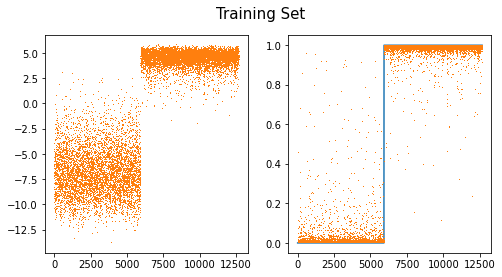

In [56]:
sftmx = torch.nn.Softmax(dim = 1)
sig = torch.nn.Sigmoid()
fig, ax = plt.subplots(1, 2, figsize = (8, 4))

ax[0].plot(net(X).diff(axis = 1).data, ',', color = "C1")
ax[1].plot(y)
ax[1].plot(sftmx(net(X))[:,1].data, ',')

fig.suptitle("Training Set", size = 15)

Text(0.5, 0.98, 'Test Set')

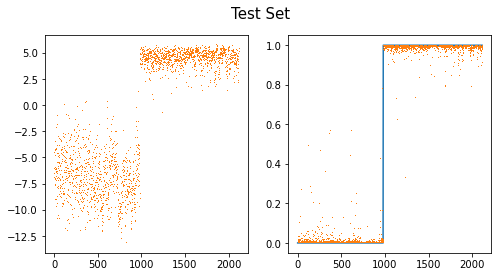

In [58]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))
ax[0].plot(net(XX).diff(axis = 1).data, ',', color = "C1")
ax[1].plot(yy)
ax[1].plot(sftmx(net(XX))[:,1].data, ',')
fig.suptitle("Test Set", size = 15)

`-` note: softmax(u1,u2)=[sig(u1-u2), sig(u2-u1)]=[1-sig(u2-u1),sig(u2-u1)]

## 이진분류에서 Softmax vs Sigmoid

`-` 이진분류문제 = "y=0 or y=1" 을 맞추는 문제 = 성공과 실패를 맞추는 문제 = 성공확률과 실패확률을 추정하는 문제 

`-` softmax, sigmoid
- softmax: (실패확률, 성공확률) 꼴로 결과가 나옴 // softmax는 실패확률과 성공확률을 둘다 추정한다. 
- sigmoid: (성공확률) 꼴로 결과가 나옴 // sigmoid는 성공확률만 추정한다. 

`-` 그런데 "실패확률=1-성공확률" 이므로 사실상 둘은 같은걸 추정하는 셈이다. (성공확률만 추정하면 실패확률은 저절로 추정되니까) 

`-` 둘은 사실상 같은 효과를 주는 모형인데 학습할 파라메터는 sigmoid의 경우가 더 적다. $\to$ sigmoid를 사용하는 모형이 비용은 싸고 효과는 동일하다는 말 $\to$ 이진분류 한정해서는 softmax를 쓰지말고 sigmoid를 써야함. 
- softmax가 갑자기 너무 안좋아보이는데 sigmoid는 k개의 클래스로 확장이 불가능한 반면 softmax는 확장이 용이하다는 장점이 있음 

## Softmax vs Sigmoid 정리

`-` 결론 
1. 소프트맥스는 시그모이드의 확장이다. 
2. 클래스의 수가 2개일 경우에는 (Sigmoid, BCEloss) 조합을 사용해야 하고 클래스의 수가 2개보다 클 경우에는 (Softmax, CrossEntropyLoss) 를 사용해야 한다. 

`-` 그런데 사실.. 클래스의 수가 2개일 경우일때 (Softmax, CrossEntropyLoss)를 사용해도 그렇게 큰일나는것은 아니다. (흑백이미지를 칼라잉크로 출력하는 느낌) 

***참고***

|$y$|분포가정|마지막층의 활성화함수|손실함수|
|:--:|:--:|:--:|:--:|
|3.45, 4.43, ... (연속형) |정규분포|None (or Identity)|MSE|
|0 or 1|이항분포 with $n=1$ (=베르누이) |Sigmoid| BCE|
|[0,0,1], [0,1,0], [1,0,0]| 다항분포 with $n=1$|Softmax| Cross Entropy |

# fastai metric 사용

## 데이터 준비

download data

In [4]:
path = untar_data(URLs.MNIST)

training set

In [37]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0, X1]) / 255
y = torch.tensor([0.0] * len(X0) + [1.0] * len(X1)).reshape(-1, 1)

test set

In [38]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
XX = torch.concat([X0, X1]) / 255
yy = torch.tensor([0.0] * len(X0) + [1.0] * len(X1)).reshape(-1, 1)

In [23]:
X.shape, XX.shape, y.shape, yy.shape

(torch.Size([12665, 1, 28, 28]),
 torch.Size([2115, 1, 28, 28]),
 torch.Size([12665, 1]),
 torch.Size([2115, 1]))

## 사용자정의 메트릭이용

### (1) dls 만들기

In [8]:
ds1 = torch.utils.data.TensorDataset(X, y)
ds2 = torch.utils.data.TensorDataset(XX, yy)
dl1 = torch.utils.data.DataLoader(ds1, batch_size = 1266)
dl2 = torch.utils.data.DataLoader(ds2, batch_size = 2115)
dls = DataLoaders(dl1, dl2)

### (2) lrnr 생성

In [9]:
net = torch.nn.Sequential(torch.nn.Conv2d(1, 16, (5, 5)),
                         torch.nn.ReLU(),
                         torch.nn.MaxPool2d((2, 2)),
                         torch.nn.Flatten(),
                         torch.nn.Linear(2304, 1),
                         torch.nn.Sigmoid())
loss_fn = torch.nn.BCELoss()

In [10]:
def acc(yhat,y) : 
    return ((yhat>0.5)==y).float().mean()

In [11]:
def err(yhat,y):
    return 1-((yhat>0.5)==y).float().mean()

In [12]:
lrnr = Learner(dls,net,loss_fn,metrics=[acc,err])

### (3) 학습

In [13]:
lrnr.fit(10)

epoch,train_loss,valid_loss,acc,err,time
0,0.964475,0.660463,0.463357,0.536643,00:02
1,0.721056,0.443165,0.996217,0.003783,00:00
2,0.571983,0.286030,0.991962,0.008038,00:00
3,0.456581,0.158378,0.992435,0.007565,00:00
4,0.359557,0.086864,0.994799,0.005201,00:00
5,0.282681,0.053276,0.995745,0.004255,00:00
6,0.223957,0.036654,0.995745,0.004255,00:00
7,0.179251,0.027493,0.995745,0.004255,00:00
8,0.144889,0.021843,0.996217,0.003783,00:00
9,0.118145,0.018024,0.997636,0.002364,00:00


### (4) 예측

`-` 생략

## fastai지원 메트릭 이용 --> 잘못된 사용

### (1) dls 만들기

In [24]:
ds1 = torch.utils.data.TensorDataset(X, y)
ds2 = torch.utils.data.TensorDataset(XX, yy)
dl1 = torch.utils.data.DataLoader(ds1, batch_size = 1266)
dl2 = torch.utils.data.DataLoader(ds2, batch_size = 2115)
dls = DataLoaders(dl1, dl2)

### (2) lrnr 생성

In [25]:
net = torch.nn.Sequential(torch.nn.Conv2d(1, 16, (5, 5)),
                         torch.nn.ReLU(),
                         torch.nn.MaxPool2d((2, 2)),
                         torch.nn.Flatten(),
                         torch.nn.Linear(2304, 1),
                         torch.nn.Sigmoid())
loss_fn = torch.nn.BCELoss()
lrnr = Learner(dls, net, loss_fn, metrics = [accuracy, error_rate])

### (3) 학습

In [26]:
lrnr.fit(10)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.063088,0.661556,0.463357,0.536643,00:00
1,0.721177,0.426138,0.463357,0.536643,00:00
2,0.574063,0.272751,0.463357,0.536643,00:00
3,0.459246,0.147063,0.463357,0.536643,00:00
4,0.359895,0.085763,0.463357,0.536643,00:00
5,0.282448,0.054518,0.463357,0.536643,00:00
6,0.224043,0.038571,0.463357,0.536643,00:00
7,0.179877,0.029486,0.463357,0.536643,00:00
8,0.145926,0.023780,0.463357,0.536643,00:00
9,0.119440,0.019887,0.463357,0.536643,00:00


In [27]:
lrnr.model.to("cpu")

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=1, bias=True)
  (5): Sigmoid()
)

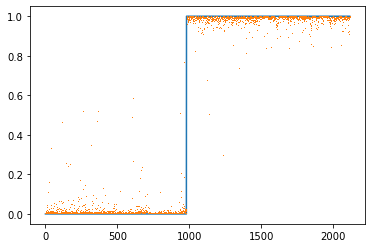

In [30]:
plt.plot(yy)
plt.plot(lrnr.model(XX).data, ',')

## fastai지원 메트릭이용 --> 올바른 사용 1

### (1) dls 만들기

In [47]:
y.to(torch.int64).reshape(-1), yy.to(torch.int64).reshape(-1)

(tensor([0, 0, 0,  ..., 1, 1, 1]), tensor([0, 0, 0,  ..., 1, 1, 1]))

In [56]:
ds1 = torch.utils.data.TensorDataset(X, y.to(torch.int64).reshape(-1))
ds2 = torch.utils.data.TensorDataset(XX, yy.to(torch.int64).reshape(-1))
dl1 = torch.utils.data.DataLoader(ds1, batch_size = 1266)
dl2 = torch.utils.data.DataLoader(ds2, batch_size = 2115)
dls = DataLoaders(dl1, dl2)

### (2) lrnr 생성

In [59]:
net = torch.nn.Sequential(torch.nn.Conv2d(1, 16, (5, 5)),
                         torch.nn.ReLU(),
                         torch.nn.MaxPool2d((2, 2)),
                         torch.nn.Flatten(),
                         torch.nn.Linear(2304, 2))
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = Learner(dls, net, loss_fn, metrics = [accuracy, error_rate])

In [60]:
lrnr.fit(10)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.169649,0.602782,0.463357,0.536643,00:00
1,0.696552,0.323619,0.954137,0.045863,00:00
2,0.519975,0.144392,0.989125,0.010875,00:00
3,0.384531,0.067986,0.994799,0.005201,00:00
4,0.287451,0.037758,0.997636,0.002364,00:00
5,0.218949,0.023339,0.998109,0.001891,00:00
6,0.169778,0.016193,0.997636,0.002364,00:00
7,0.133592,0.012137,0.997636,0.002364,00:00
8,0.106303,0.009599,0.997636,0.002364,00:00
9,0.085338,0.007887,0.997636,0.002364,00:00


## fastai지원 메트릭이용 --> 올바른 사용 2

### (1) dls 만들기

In [61]:
y_onehot = torch.tensor(list(map(lambda x : [1.0, 0.0] if x == 0 else [0.0, 1.0], y)))
yy_onehot = torch.tensor(list(map(lambda x : [1.0, 0.0] if x == 0 else [0.0, 1.0], yy)))

In [69]:
ds1 = torch.utils.data.TensorDataset(X, y_onehot)
ds2 = torch.utils.data.TensorDataset(XX, yy_onehot)
dl1 = torch.utils.data.DataLoader(ds1, batch_size = 1266)
dl2 = torch.utils.data.DataLoader(ds2, batch_size = 2115)
dls = DataLoaders(dl1, dl2)

### (2) lrnr 만들기

In [70]:
net = torch.nn.Sequential(torch.nn.Conv2d(1, 16, (5, 5)),
                         torch.nn.ReLU(),
                         torch.nn.MaxPool2d((2, 2)),
                         torch.nn.Flatten(),
                         torch.nn.Linear(2304, 2))
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = Learner(dls, net, loss_fn, metrics = [accuracy_multi])

### (3) 학습

In [71]:
lrnr.fit(10)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.167419,0.628575,0.463357,00:00
1,0.718444,0.368725,0.950118,00:00
2,0.550238,0.172170,0.991253,00:00
3,0.412260,0.081312,0.995981,00:00
4,0.309234,0.041627,0.996217,00:00
5,0.235456,0.024341,0.996454,00:00
6,0.182505,0.016696,0.997400,00:00
7,0.143571,0.012605,0.997636,00:00
8,0.114232,0.010127,0.998345,00:00
9,0.091728,0.008435,0.998345,00:00


`-` IAB 딥러닝 수업 자료를 기반으로 공부한 내용입니다.